In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 33.6 MB/s 


In [ ]:
# importing libraries

from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image
import cv2
import time
import os

In [ ]:
# initializing MTCNN and InceptionResnetV1 

mtcnn0 = MTCNN(image_size=240, margin=0, keep_all=False, min_face_size=40) # keep_all=False
mtcnn = MTCNN(image_size=240, margin=0, keep_all=True, min_face_size=40) # keep_all=True


## Highlight
resnet = InceptionResnetV1(pretrained='vggface2').eval()    

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
# Read data from folder

dataset = datasets.ImageFolder('/content/drive/MyDrive/photos') # photos folder path 
idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # accessing names of peoples from folder names

def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn)

name_list = [] # list of names corrospoing to cropped photos
embedding_list = [] # list of embeding matrix after conversion from cropped faces to embedding matrix using resnet

for img, idx in loader:
    face, prob = mtcnn0(img, return_prob=True) 
    
    if face is not None and prob>0.92:
        emb = resnet(face.unsqueeze(0)) 
        embedding_list.append(emb.detach()) 
        name_list.append(idx_to_class[idx])        

# save data
data = [embedding_list, name_list] 
torch.save(data, 'data.pt') # saving data.pt file

<IPython.core.display.Javascript object>

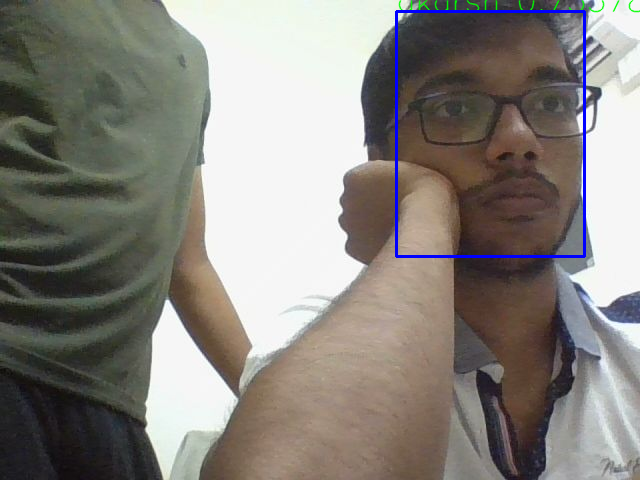

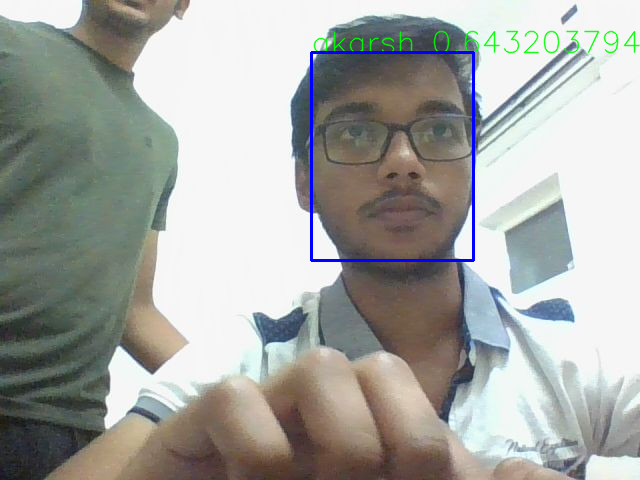

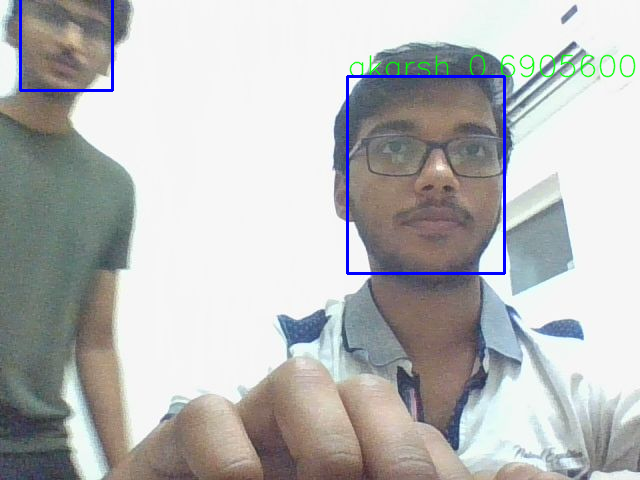

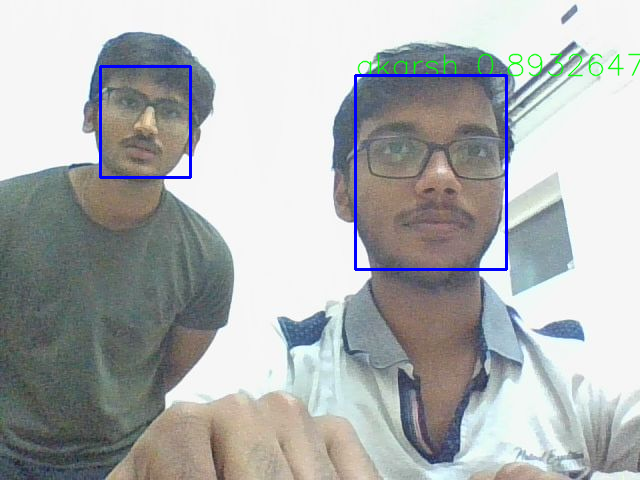

In [ ]:
# Using webcam recognize face
from google.colab.patches import cv2_imshow

# loading data.pt file
load_data = torch.load('data.pt') 
embedding_list = load_data[0] 
name_list = load_data[1] 

# cam = cv2.VideoCapture(0) 
video_stream()
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    frame_coverted = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    img = PIL.Image.fromarray(frame_coverted)

    img_cropped_list, prob_list = mtcnn(img, return_prob=True) 
    
    if img_cropped_list is not None:
        boxes, _ = mtcnn.detect(img)
                
        for i, prob in enumerate(prob_list):
            if prob>0.90:
                emb = resnet(img_cropped_list[i].unsqueeze(0)).detach() 
                
                dist_list = [] # list of matched distances, minimum distance is used to identify the person
                
                for idx, emb_db in enumerate(embedding_list):
                    dist = torch.dist(emb, emb_db).item()
                    dist_list.append(dist)

                min_dist = min(dist_list) # get minumum dist value
                min_dist_idx = dist_list.index(min_dist) # get minumum dist index
                name = name_list[min_dist_idx] # get name corrosponding to minimum dist
                
                box = boxes[i] 
                
                original_frame = frame.copy() # storing copy of frame before drawing on it
                
                if min_dist<0.90:
                    frame = cv2.putText(frame, name+' '+str(min_dist), (int(box[0]),int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),1, cv2.LINE_AA)
                
                frame = cv2.rectangle(frame, (int(box[0]),int(box[1])) , (int(box[2]),int(box[3])), (255,0,0), 2)

    cv2_imshow(frame)
        
    
    k = cv2.waitKey(1)
    if k%256==27: # ESC
        print('Esc pressed, closing...')
        break
        
    elif k%256==32: # space to save image
        print('Enter your name :')
        name = input()
        
        # create directory if not exists
        if not os.path.exists('photos/'+name):
            os.mkdir('photos/'+name)
            
        img_name = "photos/{}/{}.jpg".format(name, int(time.time()))
        cv2.imwrite(img_name, original_frame)
        print(" saved: {}".format(img_name))
        
        
# cam.release()
cv2.destroyAllWindows()